In [52]:
# Check for Catboost existence if not it will install it using pip
%pip install catboost opencv-python glob2 natsort

import os
import pandas as pd
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier

Note: you may need to restart the kernel to use updated packages.


- Performed some changes on dataset to make it easier for sorting and manipulating:
1. Splitting images from masks
2. Renaming images & masks (for sorting)

- If image has more than one mask, I combined them to be easier in performing segmentation

In [47]:
# for path in glob.glob("../Dataset/BCP_Image_Dataset/benign_images"):
#     for img_path in glob.glob(os.path.join(path,"*.png")):
#         new_name = img_path.split('\\')[-1][:-4]
#         os.rename(img_path, os.path.join(path, new_name))
# for path in glob.glob("../Dataset/BCP_Image_Dataset/benign_masks"):
#     for img_path in glob.glob(os.path.join(path,"*.png")):
#         new_name = img_path.split('\\')[-1][:-4]
#         os.rename(img_path, os.path.join(path, new_name))
# for path in glob.glob("../Dataset/BCP_Image_Dataset/malignant_images"):
#     for img_path in glob.glob(os.path.join(path,"*.png")):
#         new_name = img_path.split('\\')[-1][:-4]
#         os.rename(img_path, os.path.join(path, new_name))
# for path in glob.glob("../Dataset/BCP_Image_Dataset/malignant_masks"):
#     for img_path in glob.glob(os.path.join(path,"*.png")):
#         new_name = img_path.split('\\')[-1][:-4]
#         os.rename(img_path, os.path.join(path, new_name))

### Sorting Images

In [184]:
import natsort
xbImages = glob.glob("../Dataset/BCP_Image_Dataset/benign_images/*.png")
xbImages = natsort.natsorted(xbImages)

xmImages = glob.glob("../Dataset/BCP_Image_Dataset/malignant_images/*.png")
xmImages = natsort.natsorted(xmImages)


xbMasks = glob.glob("../Dataset/BCP_Image_Dataset/benign_masks/*.png")
xbMasks = natsort.natsorted(xbMasks)

xmMasks = glob.glob("../Dataset/BCP_Image_Dataset/malignant_masks/*.png")
xmMasks = natsort.natsorted(xmMasks)

- Creating numpy array from sorted images for training dataset (Images & Masks) 
- Resizing Images and Masks to (128x128)

In [185]:
xImages = []
yImages = []


for image in xbImages:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = cv2.resize(img, (224, 224))
    img = np.expand_dims(img, 2)
    xImages.append(img)
    yImages.append(0)

for image in xmImages:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = cv2.resize(img, (224, 224))
    img = np.expand_dims(img, 2)
    xImages.append(img)
    yImages.append(1)

xImages = np.array(xImages,dtype='f')
yImages = np.array(yImages)
print(xImages.shape)


(459, 224, 224, 1)


In [186]:
xMasks = []

for mask in xbMasks:
    msk = cv2.imread(mask, 0)
    msk = cv2.resize(msk, (224, 224))
    msk = np.expand_dims(msk, 2)
    xMasks.append(msk)

for mask in xmMasks:
    msk = cv2.imread(mask, 0)
    msk = cv2.resize(msk, (224, 224))
    msk = np.expand_dims(msk, 2)
    xMasks.append(msk)

xMasks = np.array(xMasks, dtype='f')
# Binarize Masks
xMasks = xMasks/255.0
print(xMasks.shape)


(459, 224, 224, 1)


In [187]:
# Reassuring the correctness of datasets order. 

def plotImg(idx):
    img = xImages[idx]
    mask = xMasks[idx]
    img = img.reshape(224,224)
    mask = mask.reshape(224,224)
    print("Y: ", yImages[idx])

    plt.figure(figsize=(12, 10))
    plt.subplot(221)
    plt.imshow(img,cmap='gray')
    plt.subplot(222)
    plt.imshow(mask, cmap='gray')
    plt.show()


Y:  0


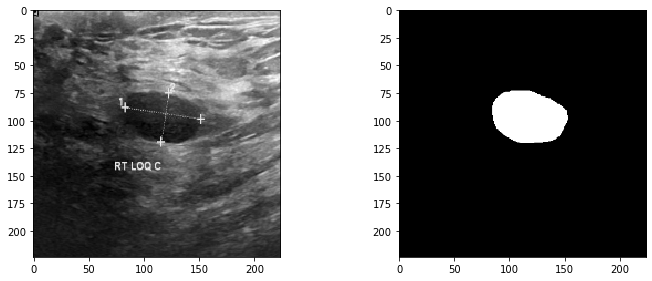

In [62]:
plotImg(258)

### Masking Images  
- Apply masks on images
- PreProcessing 
--> Normalizing data

In [188]:
for i in range(len(xImages)):
    xImages[i] = xImages[i] * xMasks[i]
    #xImages[i] = xImages[i]/255.0

Y:  0


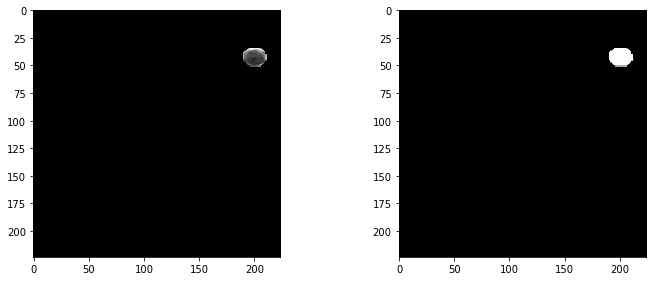

In [122]:
plotImg(201)

### Feature Extraction
- Extracting centroids from Images by calculating centroids for each image by slicing the image into chuncks of chosen windows size and calculate for each window its centroid and create feature vector for each image.

* Calculating Image Moments by these formulas:<br>
<pre>
    moments = { 'M00': arr.sum(axis=1).sum(),<br>
            'M01': (np.arange(start=1, stop=arr.shape[1] + 1, step=1) * arr.sum(axis=0).reshape(1, -1)).sum(),<br>
            'M10': (np.arange(start=1, stop=arr.shape[0] + 1, step=1) * arr.sum(axis=1).reshape(1, -1)).sum(),<br>
            'M11': 0}<br>
</pre>
* Calculate centroids for images by this formula:<br>
<pre>
    centroid{x, y} = {moments['M10'] / moments['M00'], moments['M01'] / moments['M00']}
</pre>
<br>
--> Here's some implemented function from scratch 

In [8]:
def centroid(arr):
    moments = {'M00': arr.sum(axis=1).sum(),
               'M01': (np.arange(start=1, stop=arr.shape[1] + 1, step=1) * arr.sum(axis=0).reshape(1, -1)).sum(),
               'M10': (np.arange(start=1, stop=arr.shape[0] + 1, step=1) * arr.sum(axis=1).reshape(1, -1)).sum(),
               'M11': 0}

    x = moments['M10'] / moments['M00'] if moments['M00'] != 0 else 0
    y = moments['M01'] / moments['M00'] if moments['M00'] != 0 else 0
    return [x, y]

def imageWin(trainx, r, c):
    temp = []
    for i in range(0, int(trainx.shape[0]), r):
        for j in range(0, int(trainx.shape[1]), c):
            temp.append(centroid(trainx[i:i+r, j:j+c]))
    return np.array(temp)


def slicingArray(trainX, r, c):
    featureVector = []
    for trainx in trainX:
        featureVector.append(imageWin(trainx, r, c))
    return np.array(featureVector)

Splitting and Shuffle Dataset (X & Y)

In [189]:
xtrain, xtest, ytrain, ytest = train_test_split(xImages,yImages,test_size=0.2,shuffle=True)

In [190]:
# Slicing the image and squeezing the feature vector to be 2D
trainX_fv = slicingArray(xtrain, 7, 7)
trainX_fv = trainX_fv.reshape([*trainX_fv.shape[:-2], -1])

testX_fv = slicingArray(xtest, 7, 7)
testX_fv = testX_fv.reshape([*testX_fv.shape[:-2], -1])

In [191]:
scaler = MinMaxScaler()
trainX_fv = scaler.fit_transform(trainX_fv)
testX_fv = scaler.fit_transform(testX_fv)

## Catboost Model
##### Some Definitions concerning Catboost models used below in the 2 models:
- l2_leaf_reg: Coefficient at the L2 regularization term of the cost function.
- rsm: Random subspace method. The percentage of features to use at each split selection.
- devices: Specifies the 2 categories we have.
- max_depth: each decision tree maximum depth.

##### Implemented Model
- Training Dataset = 80% of the numercical dataset
- Test Dataset = 20% of the numercical dataset

* Accuracy: 90.21%
* Model can be shrinked to 28 iteration only.

In [198]:
clf = CatBoostClassifier(iterations=30,learning_rate = 0.3, eval_metric="Accuracy", devices='0:1', max_depth=16 ,l2_leaf_reg=0.8,rsm=0.4)
clf.fit(trainX_fv,ytrain,eval_set = (testX_fv, ytest),verbose = True)

0:	learn: 0.8692098	test: 0.6521739	best: 0.6521739 (0)	total: 9.49s	remaining: 4m 35s
1:	learn: 0.9019074	test: 0.7826087	best: 0.7826087 (1)	total: 10.1s	remaining: 2m 21s
2:	learn: 0.9373297	test: 0.8260870	best: 0.8260870 (2)	total: 28.9s	remaining: 4m 20s
3:	learn: 0.9564033	test: 0.8478261	best: 0.8478261 (3)	total: 38.5s	remaining: 4m 10s
4:	learn: 0.9673025	test: 0.7826087	best: 0.8478261 (3)	total: 58.1s	remaining: 4m 50s
5:	learn: 0.9727520	test: 0.7826087	best: 0.8478261 (3)	total: 1m	remaining: 4m 2s
6:	learn: 0.9836512	test: 0.7826087	best: 0.8478261 (3)	total: 1m 19s	remaining: 4m 22s
7:	learn: 0.9918256	test: 0.8260870	best: 0.8478261 (3)	total: 1m 39s	remaining: 4m 34s
8:	learn: 0.9945504	test: 0.8478261	best: 0.8478261 (3)	total: 1m 59s	remaining: 4m 39s
9:	learn: 0.9972752	test: 0.8369565	best: 0.8478261 (3)	total: 2m 19s	remaining: 4m 39s
10:	learn: 1.0000000	test: 0.8695652	best: 0.8695652 (10)	total: 2m 39s	remaining: 4m 35s
11:	learn: 1.0000000	test: 0.8695652	bes

In [166]:
clf = CatBoostClassifier(iterations=100,learning_rate = 0.07, eval_metric="Accuracy", devices='0:1', max_depth=10,l2_leaf_reg=0.8 ,rsm=0.5)
clf.fit(trainX_fv,ytrain,eval_set = (testX_fv, ytest),verbose = True)

0:	learn: 0.7983651	test: 0.6413043	best: 0.6413043 (0)	total: 321ms	remaining: 31.7s
1:	learn: 0.8583106	test: 0.6956522	best: 0.6956522 (1)	total: 695ms	remaining: 34.1s
2:	learn: 0.8392371	test: 0.6630435	best: 0.6956522 (1)	total: 1.04s	remaining: 33.7s
3:	learn: 0.8528610	test: 0.6956522	best: 0.6956522 (1)	total: 1.41s	remaining: 33.8s
4:	learn: 0.8637602	test: 0.7282609	best: 0.7282609 (4)	total: 1.85s	remaining: 35.1s
5:	learn: 0.8446866	test: 0.7282609	best: 0.7282609 (4)	total: 1.91s	remaining: 29.9s
6:	learn: 0.8801090	test: 0.7173913	best: 0.7282609 (4)	total: 2.3s	remaining: 30.6s
7:	learn: 0.8937330	test: 0.7500000	best: 0.7500000 (7)	total: 2.72s	remaining: 31.3s
8:	learn: 0.9019074	test: 0.7391304	best: 0.7500000 (7)	total: 3.14s	remaining: 31.8s
9:	learn: 0.9073569	test: 0.7608696	best: 0.7608696 (9)	total: 3.53s	remaining: 31.8s
10:	learn: 0.9019074	test: 0.7282609	best: 0.7608696 (9)	total: 3.9s	remaining: 31.6s
11:	learn: 0.9073569	test: 0.7500000	best: 0.7608696 (9

### Some Conclusions

- Learning rates: 0.3, 0.05, 0.07 are the best
- rsm between 0.2 to 0.4 is the best
- l2_leaf_reg = 0.8 is the best
- max_depth = 10 & max_depth = 16 are the best
- using pca wasn't significant 